# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git
!pip install torchview

fatal: destination path 'ipcv-assignment-2' already exists and is not an empty directory.


In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchview import draw_graph
from torchsummary import summary
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Dict, Optional
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [ ]:
# Check for CUDA availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

Using device: cuda


In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [ ]:
# ImageNet mean and std for normalization
IMG_SIZE = (224, 224) # A common size for image classification tasks
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Create Dataset instances
train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

# Create DataLoader instances
BATCH_SIZE = 128 # You can tune this hyperparameter

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Get number of classes
NUM_CLASSES = train_dataset.get_num_classes()
INPUT_DIM = len(train_dataset[0][0])
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(train_dataset[0][0].shape)

Number of classes: 37
Training samples: 3669
Validation samples: 1834
Test samples: 1846
torch.Size([3, 224, 224])


In [ ]:
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                device: torch.device,
                scheduler: Optional[lr_scheduler.LRScheduler] = None) -> Tuple[float, float]:
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions.double() / total_samples
    return avg_loss, avg_acc.item()

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module,
                   device: torch.device) -> Tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions.double() / total_samples
    return avg_loss, avg_acc.item()

def plot_history(history: Dict[str, List[float]]):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
EPOCHS = 180

def run_experiment(config: Dict, model = None):
    print("="*60 + f"\nStart running the model: {config['experiment_name']}\n" + "="*60)
    fix_random(42)


    # Setup of Early stopping, LR schedule and weight decay
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.get("lr", 1e-3), weight_decay=config['weight_decay'])
    if config['use_scheduler']:
        warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=5)
        main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15)

    # Training Loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    pbar = tqdm(range(EPOCHS), desc=f"Training {config['experiment_name']}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        if config['use_scheduler']:
            if epoch < 5: warmup_scheduler.step()
            else: main_scheduler.step(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{config['experiment_name']}.pt")
            #print(f"Saved new best model, val acc: {val_acc}")
        pbar.set_postfix({"Val Acc": f"{val_acc:.4f}", "Train Acc": f"{train_acc:.4f}"})

    # Final test and save result
    sd = torch.load(f"{config['experiment_name']}.pt")
    model.load_state_dict(sd)
    _, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f"Model '{config['experiment_name']}' completed. Test Accuracy: {test_acc:.4f}\n")

    result = config.copy()
    result.update({'test_accuracy': test_acc, 'best_val_accuracy': best_val_acc, 'history': history})
    return result

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None,
        dropout_rate: float = 0.2
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # reinitialization of the classifier
    # model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.fc.in_features, num_classes)
        )
    return model

By default, when we load a pretrained model all of the parameters have ``.requires_grad=True``. If we want to only compute gradients for the newly initialized layers, then we want all other parameters to not require gradients.

In the case of RESNet18...

In [ ]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_transfer = get_model(NUM_CLASSES, weights).to(DEVICE)

# Freeze early layers of the network
frozen_layers = [
    net_transfer.conv1,
    net_transfer.bn1,
    net_transfer.layer1,
    net_transfer.layer2,
    net_transfer.layer3,
    net_transfer.layer4,
]

for layer in frozen_layers:
    set_requires_grad(layer, False)

summary(
    net_transfer,
    input_size=(3, 224, 224)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
EPOCHS = 30

# same training hyperparameters of our network
transfer_config= {
    "experiment_name": "resnet_transfer",
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "use_scheduler": True,
}
result = run_experiment(transfer_config, net_transfer)

df = pd.DataFrame(result).to_csv(f"./{result['experiment_name']}_differentparams.csv")
plot_history(result['history'])
print(f"\nFinal Results for {result['experiment_name']}:")
print(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f}")
print(f"Test Accuracy: {result['test_accuracy']:.4f}")

Start running the model: resnet_transfer


Training resnet_transfer: 100%|██████████| 30/30 [15:18<00:00, 30.63s/it, Val Acc=0.8926, Train Acc=0.7563]


Model 'resnet_transfer' completed. Test Accuracy: 0.8857



OSError: Cannot save file into a non-existent directory: 'output'

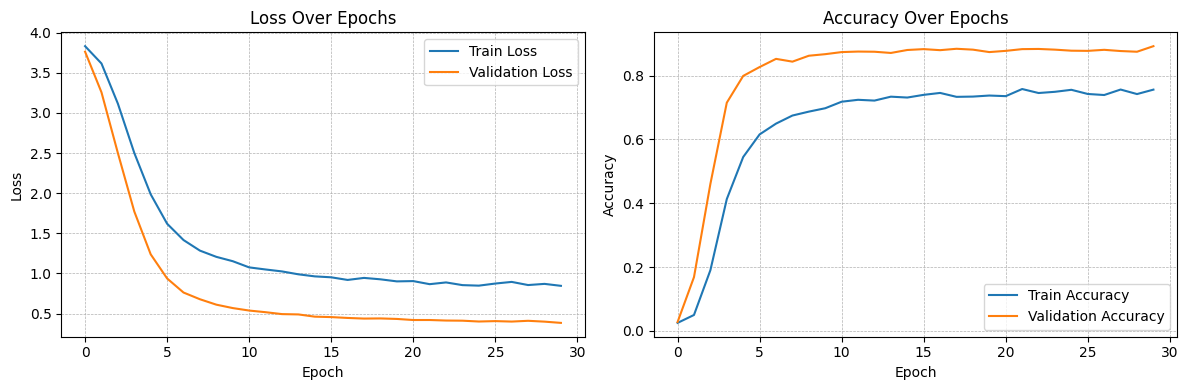


Final Results for resnet_transfer:
Best Validation Accuracy: 0.8926
Test Accuracy: 0.8857


In [ ]:
df = pd.DataFrame(result).to_csv(f"./{result['experiment_name']}_differentparams.csv")
plot_history(result['history'])
print(f"\nFinal Results for {result['experiment_name']}:")
print(f"Best Validation Accuracy: {result['best_val_accuracy']:.4f}")
print(f"Test Accuracy: {result['test_accuracy']:.4f}")